In [152]:
import os
import glob

import torch
from torch.utils.data import Dataset,DataLoader
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio

from skimage.morphology import binary_dilation
import cv2


In [98]:
#THE BANDS are BGR-NIR
#THe Bands are [B01,B02,B03,B04]
class ExploreSet(Dataset):

    def __init__(
        self,
        root = '/home/hasann/Desktop/geogroup/competition_datasets/nasa_rwanda_field_boundary_competition',
        ):

        self.root = root
        
        data = []

        for split in ['train','test']:
            img_dir = f'{root}/{split}_imgs'
            iids = [os.path.basename(f).split('_2021')[0] for f in glob.glob(f'{img_dir}/nasa_rwanda_field_boundary_competition_source*')]
            iids = list(set(iids))
            N = len(iids)
            data.extend(list(zip(iids,[split]*N)))
        
        self.months = ['03','04','08','10','11','12']
        self.year = '2021'
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    @staticmethod
    def load_channels(path):
        img = []
        for band in ['B01','B02','B03','B04']:
            img.append(rio.open(f'{path}/{band}.tif').read())
        
        img = np.vstack(img)
        return img


    
    def __getitem__(self, index,totensor = True,only_imgs=True):

        iid ,split = self.data[index]
        train_img = split == 'train'

        imgs = [] 
        for month in self.months:
            img = self.load_channels(f'{self.root}/{split}_imgs/{iid}_{self.year}_{month}')
            #print
            imgs.append(img)
        
        if train_img:
            mask_iid = iid.replace('source','labels')
            mask = rio.open(f'{self.root}/train_labels/{mask_iid}/raster_labels.tif').read()
            
        else:
            mask = None
        
        if totensor:

            imgs = np.stack(imgs,axis=0)
            #print(imgs.dtype)
            imgs = imgs.astype(np.float32)
            imgs = torch.from_numpy(imgs).float()
            if train_img:
                mask = torch.from_numpy(mask).long()
        if only_imgs:
            return imgs
        return imgs,mask
        
        

In [99]:
def normalize(img,mean,std,max_pixel_value):

    img /= max_pixel_value
    img -= mean
    img /= std

    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 0.25116277  0.2807971   0.16607776 -0.17065215]
[0.7593023  0.72735506 0.79770315 0.97499996]
[ 0.3627907   0.35597828  0.34452295 -0.36304355]
[1.110465  1.0860507 1.3551238 1.6288042]
[ 0.2767442   0.3188406   0.07773849 -0.07989132]
[1.0209303 0.8713768 1.0971731 1.1021739]
[ 0.3744186   0.33514494  0.32508835 -0.08152181]
[1.4523256 1.589674  1.590106  1.0369565]
[ 0.3523256   0.35326084  0.33745584 -0.1565218 ]
[1.017442  0.7717391 1.0026501 1.0152173]
[ 0.33372092  0.32155797  0.30123675 -0.45054352]
[2.5034885 2.473732  2.4001765 1.7010869]


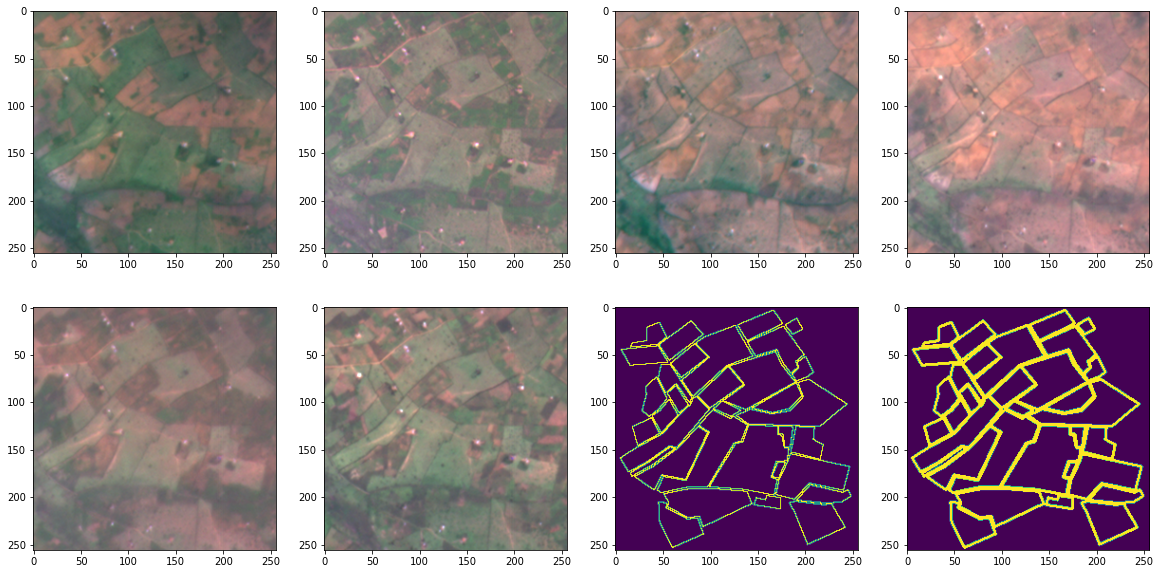

In [153]:
dataset = ExploreSet()

Mean = np.array([0.049, 0.083, 0.088, 0.303])
Std = np.array([0.215, 0.276, 0.283, 0.46])
NORM = 10000 #65535


IDX = 11
imgs,mask = dataset.__getitem__(IDX,totensor=True,only_imgs=False)


fig,axs = plt.subplots(2,4,figsize = (20,10))

B,C,H,W = imgs.shape
for i in range(B):
    img = imgs[i,...].cpu().numpy()
    #print(img.min(axis=(1,2))/NORM)
    #print(img.max(axis=(1,2))/NORM)
    
    img = img.transpose(1,2,0)
    img = normalize(img,Mean,Std,NORM)
    
    row,col = i // 4, i%4
    
    #print(img.min(axis=(0,1)))
    #print(img.max(axis=(0,1)))

    img = img *5
    img = (img + 1)/ 2

    print(img.min(axis=(0,1)))
    print(img.max(axis=(0,1)))
    rgb = img[:,:,[2,1,0]]
    axs[row,col].imshow(rgb)

mask = mask.cpu().numpy()[0]
axs[1,2].imshow(mask)
axs[1,3].imshow(binary_dilation(mask))



In [139]:
bs=1

tsize = 256
tarea = tsize ** 2
NORM = 10000

dataset = ExploreSet()
loader = DataLoader(dataset=dataset,batch_size=bs,num_workers=2,pin_memory=True)

loader = tqdm(loader)

psum  = None
psum_sq = None

count = 0
for x in loader:
    #print(x.shape)
    #x = x.cuda()
    B,T,C,H,W = x.shape
    x = x.view(B*T,C,H,W)

    #print(x.shape)
    
    x = x / NORM

    psum_now = x.sum(axis=[0, 2, 3]).unsqueeze(0)
    psum_sq_now = (x ** 2).sum(axis=[0, 2, 3]).unsqueeze(0)

    if psum is None:
        psum = psum_now
        psum_sq = psum_sq_now
    else:
        psum = torch.cat([psum,psum_now],dim=0)
        psum_sq = torch.cat([psum_sq,psum_sq_now],dim=0)

    count += (B*T)

count *= tarea
total_mean = (psum / count).sum(dim=0)
total_var = (psum / count).sum(dim=0) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

  0%|          | 0/70 [00:00<?, ?it/s]

In [134]:
max = None
for x in loader:

    B,T,C,H,W = x.shape
    x = x.view(B*T,C,-1)
    x = x.permute(1,0,-1)
    x = x.reshape(C,-1)
    #print(x.shape)
    #print(x.max(dim=1))
    max_now ,_= x.max(dim=1)
    print(max_now)
    if max is None:
        max = max_now
    else:
        max,_ = torch.cat([max,max_now]).view(2,C).max(dim=0)
        print(max)


tensor([4088., 4003., 6067., 5363.])
tensor([4795., 5627., 8814., 9989.])
tensor([4795., 5627., 8814., 9989.])
tensor([4251., 4589., 6381., 7041.])
tensor([4795., 5627., 8814., 9989.])
tensor([2499., 3400., 3602., 5373.])
tensor([4795., 5627., 8814., 9989.])
tensor([3370., 3773., 4159., 5706.])
tensor([4795., 5627., 8814., 9989.])
tensor([2346., 2534., 2904., 6340.])
tensor([4795., 5627., 8814., 9989.])
tensor([1867., 2713., 2646., 6512.])
tensor([4795., 5627., 8814., 9989.])
tensor([4064., 5064., 7818., 6710.])
tensor([4795., 5627., 8814., 9989.])
tensor([3299., 2363., 2900., 5297.])
tensor([4795., 5627., 8814., 9989.])
tensor([1811., 2185., 2405., 5157.])
tensor([4795., 5627., 8814., 9989.])
tensor([2632., 2656., 3186., 4893.])
tensor([4795., 5627., 8814., 9989.])
tensor([2213., 3009., 3031., 5240.])
tensor([4795., 5627., 8814., 9989.])
tensor([1633., 2249., 2561., 5316.])
tensor([4795., 5627., 8814., 9989.])
tensor([2034., 2619., 2530., 5375.])
tensor([4795., 5627., 8814., 9989.])
t

In [141]:
print('Mean:',np.around(total_mean.cpu().numpy(),decimals=5).tolist())
print('Std:' , np.around(total_std.cpu().numpy(),decimals=5).tolist())

Mean: [0.04842999950051308, 0.08291000127792358, 0.0880500003695488, 0.3029400110244751]
Std: [0.21467000246047974, 0.27573999762535095, 0.2833699882030487, 0.4595299959182739]
